In [ ]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm

import numpy as np
import pandas as pd
from scipy.stats import t
from scipy.stats import norm

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split  
from sklearn.datasets import load_diabetes

import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set('notebook', font_scale=1.7)
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Линейная регрессия


Скачаем <a href="https://raw.githubusercontent.com/bdemeshev/em301/master/datasets/flats_moscow.txt">данные</a> о стоимости квартир в Москве.	Описание: <a href="https://github.com/bdemeshev/em301/blob/master/datasets/flats_moscow_description.txt">ccылка</a>.


In [ ]:
data = pd.read_table('flats_moscow.txt').set_index('n')  # считываем даные
data.head()

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
n,,,,,,,,,,
1,81,58,40,6.0,12.5,7,1,1,1,3
2,75,44,28,6.0,13.5,7,1,0,1,6
3,128,70,42,6.0,14.5,3,1,1,1,3
4,95,61,37,6.0,13.5,7,1,0,1,1
5,330,104,60,11.0,10.5,7,0,1,1,3


In [ ]:
Scaler = StandardScaler() # создаем экземпляр скейлера
for column in data.drop('price', axis=1).columns:
  data[column] = Scaler.fit_transform(data[column].to_numpy().reshape(-1, 1)) # стандартизируем каждую колонку

In [ ]:
data = sm.add_constant(data) # добавляем константный признак
X_train, X_test, y_train, y_test = train_test_split(data.drop('price', axis=1), data['price']) # разбиваем выборку на train и test
model = sm.OLS(y_train, X_train).fit() # обучаем модель
print(model.summary()) # смотрим результат

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     352.7
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        17:15:13   Log-Likelihood:                -7358.2
No. Observations:                1530   AIC:                         1.474e+04
Df Residuals:                    1520   BIC:                         1.479e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        127.4695      0.761    167.396      0.0

In [ ]:
r2_score(model.predict(X_test), y_test) # Смотрим качество модели на тесте

0.5579679188682194

Чтобы купить квартиру, в которой я хочу жить, мне придется накопить от 54 до 66 тысяч долларов.

# Regularization


Скачаем данные <a href="https://archive.ics.uci.edu/ml/datasets/Parkinsons+Telemonitoring">`Parkinsons telemonitoring`</a>.

In [ ]:
data = pd.read_csv('parkinsons_updrs.data')
data.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


Нас интересует предсказание `total_UPDRS` &mdash; степени заболевания. Для корректной постановки задачи удалим из данных столбец `motor_UPDRS`, так как это тоже мера тяжести заболевания, но лишь в аспекте моторных нарушений. Будем предсказывать значение `total_UPDRS` в зависимости от остальных признаков. 

В данных есть группы (паценты). Колонку `subject#` следует использовать не в качестве признака, а в качестве группы. Разделим данные на признаки $X$, таргет $y$ и массив номеров групп.

In [ ]:
data = data.drop('motor_UPDRS', 1) # выкидываем ненужный столбец
y = np.array(data['total_UPDRS']) # target
X = np.array(data.drop(['subject#', 'total_UPDRS'], axis=1)) # features
group_numbers = np.array(data['subject#']) # группы

Разобъем данные на обучающую и тестовую выборку

In [ ]:
gss = GroupShuffleSplit(n_splits=5, test_size=0.27, random_state=1)
train_idx, test_idx = next(gss.split(X, y, groups = group_numbers)) # определяем, какие индексы попадут в трейн, а какие в етст
Scaler = StandardScaler()
Scaler.fit(X[train_idx]) # обучаем стандарт скейлер
X_train, X_test = Scaler.transform(X[train_idx]), Scaler.transform(X[test_idx]) # нормализуем данные
y_train, y_test = y[train_idx] - y[train_idx].mean(), y[test_idx] - y[train_idx].mean()

Исследуем зависимость значений коэффициентов от параметра регуляризации `alpha` для Ridge, Lasso, Elastic регрессий. Для Elastic также исследуем зависимость от параметра `l1_ratio`.

In [ ]:
def draw_track(model, X, y, log_min, log_max, num, title='', figsize=(12, 9)):
    """Данная функция строит график зависимости значений 
    коэффициентов модели от параметра регуляризации.
    
    :param model: модель
    :param X: регрессоры
    :param y: отклик
    :param log_min: десятичный логарифм 
        минимального значения коэффициента регуляризации
    :param log_max: десятичный логарифм 
        максимального значения коэффициента регуляризации
    :param num: количество элементов в сетке для коэффициента регуляризации
    :param title: заголовок графика
    :param figsize: размер полотна
    """
    alphas = np.logspace(log_min, log_max, num)   
    coefs = []
    for a in alphas:
        if 'l1_ratio' in model.get_params():
            # равномерно распределим alpha по обоим коэффициентам
            a *= 3/2
            model.set_params(alpha=a)
        else:
            model.set_params(alpha=a)
        model.fit(X, y)
        coefs.append(model.coef_)

    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.hlines(0, 10 ** log_min, 10 ** log_max, linewidth=15, alpha=0.15)
    ind = 1
    for coef in np.array(coefs).T:
        label = r'$\theta_{' + str(ind) + '}$'
        ax.plot(alphas, coef, linewidth=2, label=label)
        ind += 1
        
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel('alpha', fontsize=19)
    plt.ylabel('weights', fontsize=19)
    plt.title(title, fontsize=22)
    plt.legend(loc='upper left', fontsize=15)
    plt.axis('tight')
    plt.show()

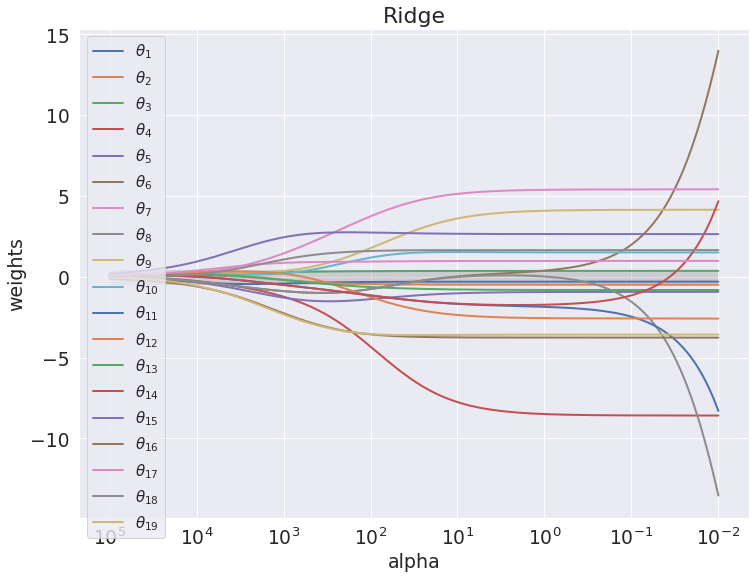

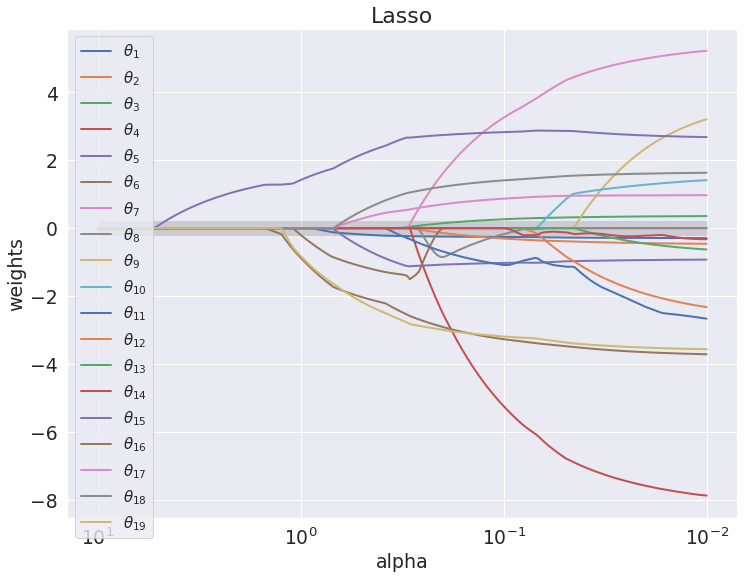

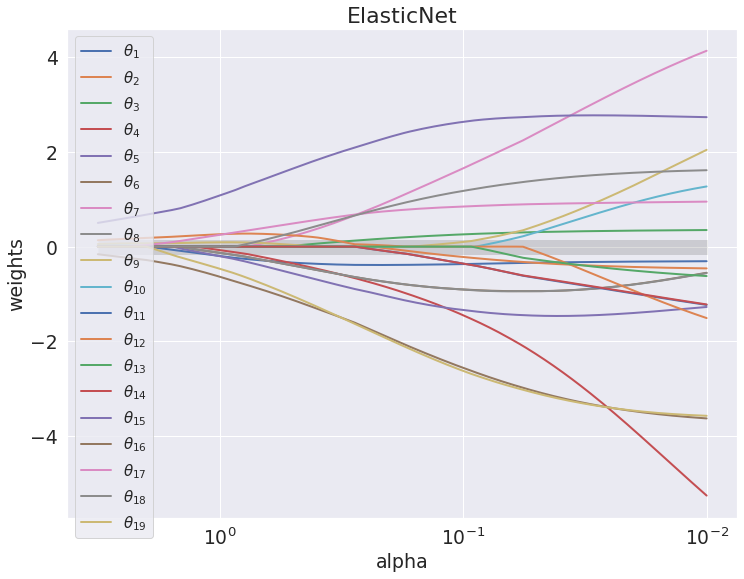

In [ ]:
draw_track(Ridge(fit_intercept=False), Scaler.transform(X), y, -2, 5, 200, 
           title='Ridge')
draw_track(Lasso(fit_intercept=False), Scaler.transform(X), y, -2, 1, 200, 
           title='Lasso')
draw_track(ElasticNet(fit_intercept=False, l1_ratio=1/3), Scaler.transform(X), y, -2, 0.5, 200, 
           title='ElasticNet')

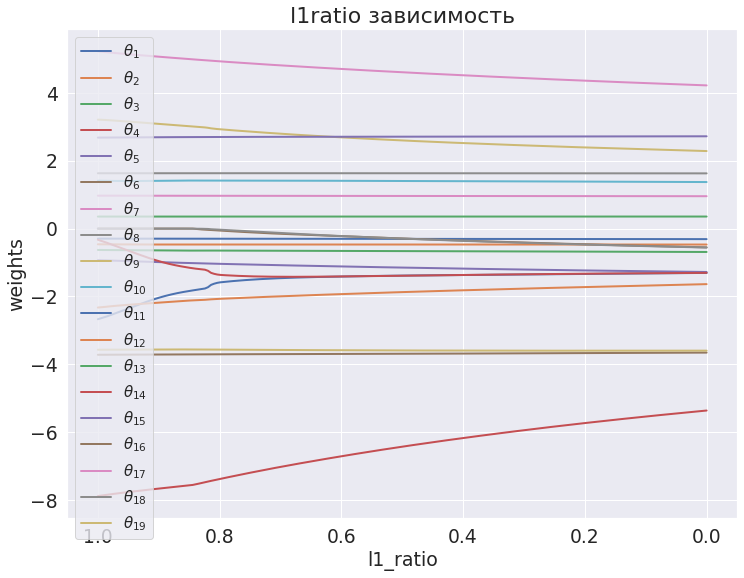

In [ ]:
def draw_l1ratio(model, X, y, log_min, log_max, num, title='', figsize=(12, 9)): 
    alpha = 0.01   
    coefs = []
    l1ratio = np.linspace(0, 1, num)
    for l in l1ratio:        
        model.set_params(l1_ratio=l, alpha=0.01)
        model.fit(X, y)
        coefs.append(model.coef_)

    plt.figure(figsize=figsize)
    ax = plt.gca()
    ind = 1
    for coef in np.array(coefs).T:
        label = r'$\theta_{' + str(ind) + '}$'
        ax.plot(l1ratio, coef, linewidth=2, label=label)
        ind += 1
        
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel('l1_ratio', fontsize=19)
    plt.ylabel('weights', fontsize=19)
    plt.title(title, fontsize=22)
    plt.legend(loc='upper left', fontsize=15)
    plt.axis('tight')
    plt.show()
draw_l1ratio(ElasticNet(fit_intercept=False), Scaler.transform(X), y, -2, 0.5, 200, 
           title='l1ratio зависимость')

# GridSearch и CrossValidation

С помощью кросс-валидации определим наилучшие параметры для Ridge, Lasso, Elastic моделей.

In [ ]:
steps = [('scaling', StandardScaler()), ('model', ElasticNet())] # шаги
pipeline = Pipeline(steps)
pipeline

Pipeline(steps=[('scaling', StandardScaler()), ('model', ElasticNet())])

In [ ]:
parameteres = {'model__l1_ratio': [0.1*i for i in range(11)], 'model__alpha' : [0.1 * i for i in range(100)]} # сетка параметров
search = GridSearchCV(pipeline, parameteres, cv=gss) # наш поиск
search

GridSearchCV(cv=GroupShuffleSplit(n_splits=5, random_state=1, test_size=0.27, train_size=None),
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('model', ElasticNet())]),
             param_grid={'model__alpha': [0.0, 0.1, 0.2, 0.30000000000000004,
                                          0.4, 0.5, 0.6000000000000001,
                                          0.7000000000000001, 0.8, 0.9, 1.0,
                                          1.1, 1.2000000000000002, 1.3,
                                          1.4000000000000001, 1.5, 1.6,
                                          1.7000000000000002, 1.8,
                                          1.9000000000000001, 2.0, 2.1, 2.2,
                                          2.3000000000000003,
                                          2.4000000000000004, 2.5, 2.6, 2.7,
                                          2.8000000000000003,
                                          2.90000000

In [ ]:
search.fit(X_train, y_train, groups=group_numbers[train_idx])

GridSearchCV(cv=GroupShuffleSplit(n_splits=5, random_state=1, test_size=0.27, train_size=None),
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('model', ElasticNet())]),
             param_grid={'model__alpha': [0.0, 0.1, 0.2, 0.30000000000000004,
                                          0.4, 0.5, 0.6000000000000001,
                                          0.7000000000000001, 0.8, 0.9, 1.0,
                                          1.1, 1.2000000000000002, 1.3,
                                          1.4000000000000001, 1.5, 1.6,
                                          1.7000000000000002, 1.8,
                                          1.9000000000000001, 2.0, 2.1, 2.2,
                                          2.3000000000000003,
                                          2.4000000000000004, 2.5, 2.6, 2.7,
                                          2.8000000000000003,
                                          2.90000000

In [ ]:
mse(search.best_estimator_.predict(X_test), y_test)

139.50475984061427

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
mse(model.predict(X_test), y_test)

162.9413531794944